Using device: cuda
Epoch 1/10 - Loss: 0.6837, Accuracy: 54.38%
Epoch 2/10 - Loss: 0.5913, Accuracy: 70.00%
Epoch 3/10 - Loss: 0.4544, Accuracy: 78.75%
Epoch 4/10 - Loss: 0.3515, Accuracy: 84.62%
Epoch 5/10 - Loss: 0.2822, Accuracy: 88.12%
Epoch 6/10 - Loss: 0.2370, Accuracy: 90.88%
Epoch 7/10 - Loss: 0.1907, Accuracy: 92.62%
Epoch 8/10 - Loss: 0.1671, Accuracy: 94.50%
Epoch 9/10 - Loss: 0.1383, Accuracy: 95.38%
Epoch 10/10 - Loss: 0.1125, Accuracy: 96.38%


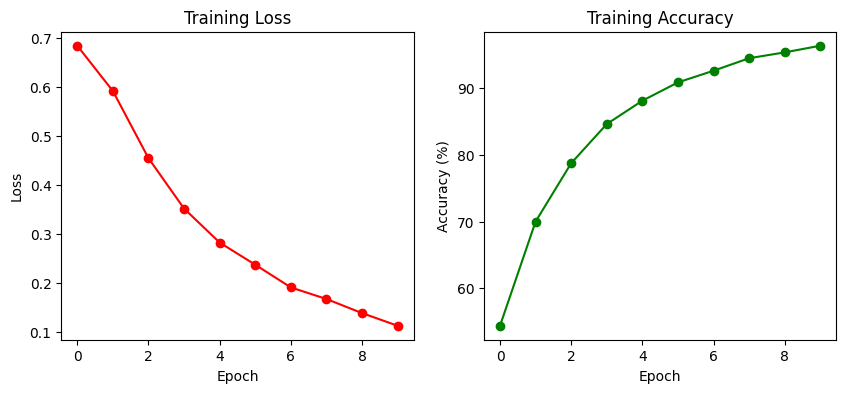

✅ Test Accuracy: 87.50%


In [ ]:
#RNN
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Each sequence is a list of integers (simulating words)
vocab_size = 50   # number of "words"
seq_length = 10   # words per sequence
num_samples = 1000

# Generate random sequences
X = torch.randint(0, vocab_size, (num_samples, seq_length))
# Labels: 1 if sum of sequence > median, else 0
y = (X.sum(dim=1) > (seq_length * vocab_size // 2)).long()

# Train/test split
train_X, test_X = X[:800], X[800:]
train_y, test_y = y[:800], y[800:]

train_loader = DataLoader(TensorDataset(train_X, train_y), batch_size=32, shuffle=True)
test_loader  = DataLoader(TensorDataset(test_X, test_y), batch_size=32, shuffle=False)

class TextRNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super(TextRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.RNN(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # last timestep
        return out

embed_dim = 32
hidden_dim = 64
output_dim = 2

model = TextRNN(vocab_size, embed_dim, hidden_dim, output_dim).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 10
train_losses, train_acc = [], []

for epoch in range(epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(train_loader)
    acc = 100 * correct / total
    train_losses.append(avg_loss)
    train_acc.append(acc)
    print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}, Accuracy: {acc:.2f}%")

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, 'r-o')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1,2,2)
plt.plot(train_acc, 'g-o')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.show()

model.eval()
correct, total = 0, 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"✅ Test Accuracy: {100*correct/total:.2f}%")
